# Scrpt for plotting the training result copied from PACE.


## Step 0: Define functions to deal with different types of data files.

### Loss function history - reads the loss history of each client, then plot them together. Alternatively, it could plot the average loss instead of plotting individual losses.

In [1]:
# Plot methods
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def plot_loss_hist(hists, savefig='', uselog=True, multiclient=False, uselegend=False):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,7))
    fig.suptitle('Top: loss per iteartion; Bottom: avg loss per epoch')
    
    if multiclient:
        sum_hist = []
        for chist in hists:
            
            all_hist = []
            for h in chist:
                all_hist.extend(h)
            avg_hist = [np.mean(h) for h in chist]
            
            max_num_iteration = len(all_hist)
            num_epoch = len(chist)

            if len(sum_hist) == 0:
                sum_hist = avg_hist
            else:
                if (len(sum_hist) < num_epoch):
                    sum_hist += [0] * (num_epoch - len(sum_hist))
                sum_hist = [sum_hist[i]+avg_hist[i] for i in range(num_epoch)]

            ax1.plot(np.arange(max_num_iteration), all_hist)
            
        sum_hist = [h/len(hists) for h in sum_hist]
        ax2.bar(np.arange(num_epoch), sum_hist) #avg_hist)
    else:
        all_hist = []
        for h in hists:
            all_hist.extend(h)
        avg_hist = [np.mean(h) for h in hists]

        max_num_iteration = len(all_hist)
        num_epoch = len(hists)

        ax1.plot(np.arange(max_num_iteration), all_hist)
        ax2.bar(np.arange(num_epoch), avg_hist)
    
    if uselog:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
    
    if uselegend:
        ax1.legend(np.arange(len(hists[0])))
    
    ax1.set_ylabel('Loss history')
    ax1.set_ylabel('# of iterations (merged)')
    ax1.set_ylabel('Loss history (average)')
    ax2.set_xlabel('# of epochs')
    
    if len(savefig) > 0:
        plt.savefig(savefig+'.jpg')
    

### Plot the history of every pairwise model distance that was available in the loaded data file

In [2]:
def plot_dist_per_ep(dists, savefig='', uselog=True, avg_iter_ind=-1):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,7))
    if avg_iter_ind < 0:
        indtext = 'final'
    else:
        indtext = str(avg_iter_ind)+'th'
    fig.suptitle('Top: distance at the {} iteration during consensus, per epoch; \n\
    Bottom: Total distance at the {} consensus iteration over each epoch'.format(indtext,indtext))
    # graphical representation if I ever figure out how to do it')
    
    x_axis = np.arange(dists.shape[3])
    sum_dist = np.zeros((dists.shape[3],))
    for i in range(dists.shape[0]):
        for j in range(i+1, dists.shape[1]):
            ax1.plot(x_axis, dists[i,j,avg_iter_ind,:])
            sum_dist += dists[i,j,avg_iter_ind,:]
    ax1.grid(True)
    ax2.bar(x_axis, sum_dist)
    ax2.grid(True)
    
    if uselog:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
#     plt.grid()
    
    ax1.set_ylabel('Distance')
    ax1.set_ylabel('# of epochs')
    ax1.set_ylabel('Distance (sum)')
    ax2.set_xlabel('# of epochs')
    
    if len(savefig) > 0:
        plt.savefig('Nonconsensus_'+savefig+'.jpg')
    

### Plot accuracy history of each client / of overall average. In addition, the methods below could find out the first epoch where a model's performance crosses a certain accuracy, and print it out.

In [3]:
def find_accuracy_first_thres(hist, thres=[]):
    # Arguments: "hist" is the list of accuracy history. "thres" is the list of accuracy milestones
    # that we are interested in (and should be increasing to be meaningful).
    # Output: A list of indices, each corresponding to the first index where the accuracy has 
    # exceeded the milestone at the same place. Would be -1 if never exceeded.
    output_list = -np.ones((len(thres),), dtype=int)
    if len(thres) <= 0:
        return output_list
    
    ti = 0
    for di in range(len(hist)):
        while (hist[di] >= thres[ti]):
            output_list[ti] = (di+1)
            ti += 1
            if (ti >= len(thres)):
                return output_list
        
    return output_list

You can determine if you want to plot out the top-performing model's performances, or want the average model's performance, or want all models to be plotted together.

In [482]:
def plot_accuracy_history(hist, legend=None, show_max_only=False, 
                          accuracy_thresholds=[], use_avg=False, old_compatible=False, title=''):
    fig, (axes, logaxes) = plt.subplots(1,2, figsize=(12,4))
    axes.set_xlabel('# of epochs')
    axes.set_ylabel('Accuracy')
    
    logaxes.set_xlabel('# of epochs')
    logaxes.set_ylabel('Log Accuracy')
    logaxes.set_xscale('log')
    
    if old_compatible:
        hist = [[h] for h in hist]
    
    max_hist = [max(h) for h in hist]
    if use_avg:
        max_hist = [np.average(h) for h in hist]
        axes.set_ylabel('Average accuracy')
        axes.plot(np.arange(len(hist)), max_hist)
        logaxes.plot(np.arange(len(hist)), max_hist)
    elif show_max_only:
        axes.plot(np.arange(len(hist)), max_hist)
        logaxes.plot(np.arange(len(hist)), max_hist)
    else:
        for i in range(len(hist[0])):
            axes.plot(np.arange(len(hist)), [h[i] for h in hist])
            logaxes.plot(np.arange(len(hist)), [h[i] for h in hist])
    if legend is not None:
        axes.legend(legend)
    else:
        axes.legend(np.arange(1, 1+len(hist[0])))
    axes.set_title(title)
    
    print("Accuracy threshold values and corresponding indices: ")
    if not isinstance(accuracy_thresholds[0], list):
        accuracy_thresholds = [accuracy_thresholds]
    for ats in accuracy_thresholds:
        print(np.array(ats))
        print(find_accuracy_first_thres(max_hist, ats))
    
    Imax = np.argmax(max_hist)
    print('Max index and accuracy at there: \n', 1+Imax, max_hist[Imax])

In [493]:
def plot_avg_accuracy_histories(histnames, legend=None, show_max_only=False, 
                          accuracy_thresholds=[], use_avg=False, old_compatible=False, title=''):
    fig, (axes, logaxes) = plt.subplots(1,2, figsize=(12,4))
    axes.set_xlabel('# of epochs')
    axes.set_ylabel('Accuracy')
    
    logaxes.set_xlabel('# of epochs')
    logaxes.set_ylabel('Log Accuracy')
    logaxes.set_xscale('log')
    
    thres_ind_list = []
    max_ind_list = []
    max_acc_list = []
    
    for hn in histnames:
        hist = np.load(hn+'Accuracy.npy', allow_pickle=True)
    
        if old_compatible:
            hist = [[h] for h in hist]

        max_hist = [max(h) for h in hist]
        if use_avg:
            max_hist = [np.average(h) for h in hist]
            axes.set_ylabel('Average accuracy')
            axes.plot(np.arange(len(hist)), max_hist)
            logaxes.plot(np.arange(len(hist)), max_hist)
        elif show_max_only:
            axes.plot(np.arange(len(hist)), max_hist)
            logaxes.plot(np.arange(len(hist)), max_hist)
        else:
            print("You can't plot all the histories here. Choose either average or max accuracy.")
        if legend is not None:
            axes.legend(legend)
        else:
            axes.legend(np.arange(1, 1+len(hist[0])))
        axes.set_title(title)
        
        if not isinstance(accuracy_thresholds[0], list):
            accuracy_thresholds = [accuracy_thresholds]
        thrind_list = []
        for ats in accuracy_thresholds:
            thrind_list.append(find_accuracy_first_thres(max_hist, ats))
        thres_ind_list.append(thrind_list)
        
        Imax = np.argmax(max_hist)
        max_ind_list.append(Imax)
        max_acc_list.append(max_hist[Imax])
    
    print("Accuracy threshold values and corresponding indices: ")
    print(np.array(accuracy_thresholds))
    for thrind_list in thres_ind_list:
        print(thrind_list)
    
    print('Max index and accuracy at there:')
    print(np.array(max_ind_list))
    print(np.array(max_acc_list))

## Step 1: Specify the file name. You might want to plot several files at once, so you'll have to use one of the templates below that are capable of fitting different values at the right spot.

In [751]:
# namebase = 'npy_datas/MNIST_DFL_full_dataset_K10_C1_E1__INDIV_'
# namebase = 'npy_datas/MNIST_DFL_full_dataset_K10_C1_E1__INDIV_'
namebase = 'npy_datas/MNIST_DFL_diverseClient2_dataset_K10_C1_E1_S1.0_M1_V0.7__INDIV_'
namebase = 'npy_datas/MNIST_DFL_repeated_dataset_K{}_C1_E5_S{}_M1_V0_'.format(30,0.5)

In [199]:
K=20
sgd_type = 'B1'
postfix = 'SameInit_Unbalanced'
namebase = 'npy_datas/MNIST_DFL_diverseSGD{0}{1}dataset_K20_C1_E1_S{2}_M1_V0.7_divUnbE1Class{3}_classp_{4}_'.format(
    sgd_type,postfix,1.0, 10,1.0)

In [256]:
# namebase = 'npy_datas/MNIST_DFL_split_dataset_'
K = 10
E = 0.05
R = 3
S = 1.0
# namebase = 'npy_datas/MNIST_DFL_split_dataset_K{}_C1_E0.05_M1_V10_'.format(K)
# namebase = 'npy_datas/MNIST_DFL_full_dataset_K{}_C1_E0.05_'.format(K)
namebase = 'npy_datas/MNIST_DFL_split_Sameinit_dataset_K{}_C1_E0.05_'.format(K)
# namebase = 'npy_datas/MNIST_DFL_E2_split_Sameinit_Unbalanceddataset_K{}_C1_E0.01_'.format(K)
# namebase = 'npy_datas/MNIST_DFL_full_dataset_K{}_C1_E10_'.format(K)
# namebase = 'npy_datas/MNIST_DFL_noconsensus_split_dataset_K{}_C1_E0.05_'.format(K)

# namebase = 'npy_datas/MNIST_DFL_segment_dataset_K{}_C1_E{}_S{}_Set8_R{}_M1_V0_'.format(K,E,0,R)
# namebase = 'npy_datas/MNIST_DFL_overlap_dataset_K{}_C1_E0.05_S{}_M1_V10_'.format(K,S)
# namebase = 'npy_datas/MNIST_DFL_repeated_dataset_K{}_C1_E0.05_S{}_M1_V0_'.format(K,S)
# namebase = 'npy_datas/MNIST_DFL_repeated_dataset_K30_C1_E1_S0.5'

# Type = '6sa'
# namebase = 'npy_datas/MNIST_DFL_diverseClient{}_dataset_K{}_C1_E{}_S{}_M1_V0.7_'.format(Type,K,E,S)
# namebase = 'npy_datas/MNIST_DFL_A_split_Sameinit_Unbalanceddataset_K{}_C1_E0.01_'.format(K)

sgd_type = 'F_DEs'
# sgd_type = 'A' # A, Ao3, Cc2, D45, E2, Ec12
# sgd_type = 'G_C3D4E3'
postfix = '_'
postfix = '_Unbalanced'
# postfix = 'SameInit_'
# postfix = 'SameInit_Unbalanced'
# namebase = 'npy_datas/MNIST_DFL_diverseLossX{}{}{}dataset_K{}_C1_E{}_S{}_M1_V0.7_'.format('10',sgd_type,postfix,K,E,S)
# E=1
namebase = 'npy_datas/MNIST_DFL_diverseSGD{}dataset_K{}_C1_E{}_S{}_M1_V0.7_'.format(sgd_type+postfix,K,E,0.01)#S)

sgd_type = 'D3'
# postfix = '_'
postfix = 'SameInit_'
# postfix = 'SameInit_Unbalanced'
namebase = 'npy_datas/MNIST_DFL_diverseNorm{}{}dataset_K10_C1_E0.05_S{}_M1_V0.7_'.format(sgd_type,postfix,0.0)

# namebase = 'npy_datas/MNIST_DFL_extCom{}{}dataset_K{}_C1_E{}_S{}_M1_V0.0_'.format(
#     sgd_type, postfix, 50, 5.0, 0.05)

# namebase = 'npy_datas/CIFAR_DFL_diverseSGD{}dataset_K{}_C1_E{}_S{}_M1_V0.7_'.format(sgd_type+postfix,K,E,0.0)#S)
# namebase = 'npy_datas/MNIST_DFL_diverseSGD{0}{1}dataset_K{2}_C1_E0.05_S0.05_M1_V0.0_firstTry_varK_{0}_-k_4_-s_0.05_-S_-AET_1_-K_{2}'.format(
#     sgd_type,postfix,100)
# namebase = 'npy_datas/MNIST_DFL_extCom{0}{1}dataset_K50_C1_E0.05_S0.05_M1_V0.0_K50_varAET_{0}_-k_4_-s_0.05_-K_50_-S_-AET_{2}'.format(
#     sgd_type,postfix,10)
# namebase = 'npy_datas/MNIST_DFL_extCom{0}{1}dataset_K50_C1_E1.0_S0.05_M1_V0.0_K50_vark_{0}_-EE_1_-s_0.05_-K_50_-S_-AET_1_-k_{2}'.format(
#     sgd_type,postfix,2)
# namebase = 'npy_datas/MNIST_DFL_extCom{0}{1}dataset_K50_C1_E{2}_S0.05_M1_V0.0_K50_varEE_{0}_-k_4_-s_0.05_-K_50_-S_-AET_1_-EE_{3}'.format(
#     sgd_type,postfix,5.0,5)
# namebase = 'npy_datas/MNIST_DFL_extCom{0}{1}dataset_K50_C1_E1.0_S0.05_M1_V0.0_K50_varp_{0}_-EE_1_-k_4_-s_0.05_-K_50_-S_-AET_1_-p_{2}'.format(
#     sgd_type,postfix,0.1)

namebase = 'npy_datas/CIFAR_DFL_diverseSGD{0}{1}dataset_K10_C1_E1_S{2}_M1_V0_'.format(sgd_type,postfix,4.0)
# namebase = 'npy_datas/CIFAR_DFL_diverseSGD{0}{1}dataset_K20_C1_E5_S{2}_M1_V0_'.format(sgd_type,postfix,0.0)


In [742]:
namebase='npy_datas/CIFAR_DFL_reduceComASameInit_dataset_Channel_Undirected_postFix_{2}k4_A_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-EE_1_-SM_cu_-PSS_{1}'.format(
50, 0.1, 'SW')

namebase='npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cu{2}_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_cu_-PSS_{1}'.format(
200, 0.5, 'AK')
# 

In [1290]:
namebase=\
'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_srn_FirstTest_MNIST_cuCRS_B1_-k_4_-Adj_AK_-S_-K_20_-SM_cu_-SRN_-CRS_-PSS_{0}'.format(
0.5)

## Step 2: Call the pre-defined functions to draw the recorded values. The default order, (in the following cells), is training loss -> testing loss -> accuracy -> model distance over time 

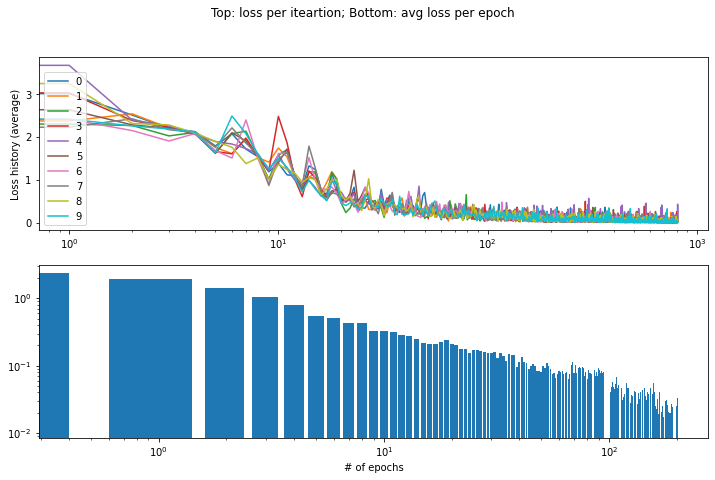

In [1284]:
#### Plot training loss history for all clients
all_client_DFL_loss_history = []
for i in range(K):
    client_DFL_loss_history = np.load(namebase+'client_{}_loss_history.npy'.format(i), allow_pickle=True)
    all_client_DFL_loss_history.append(client_DFL_loss_history)
plot_loss_hist(all_client_DFL_loss_history, multiclient=True, uselegend=True)#, uselog=False)

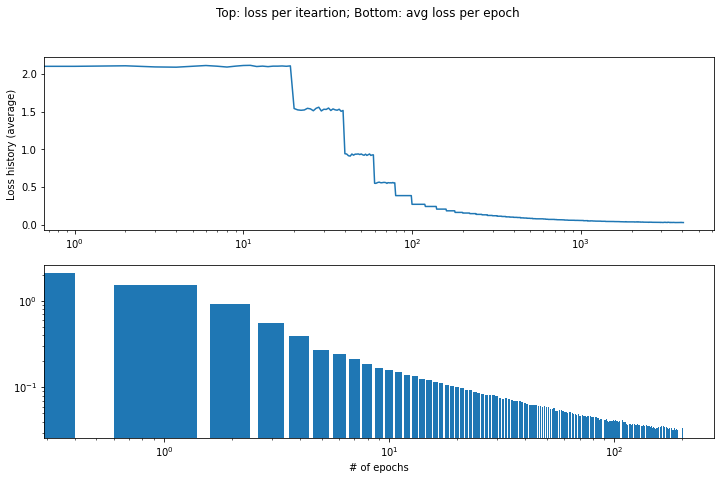

In [1287]:
DFL_loss_history = np.load(namebase+'average_loss_history.npy', allow_pickle=True)
plot_loss_hist(DFL_loss_history)#, uselog=False)
# First graph is kind of irrevelant - it plots in chunks of 10, where each chunk contains info from each client

Accuracy threshold values and corresponding indices: 
[20 40 50 70]
[1 1 1 2]
[80 85 90 93]
[ 3  4  5 10]
[95.  96.  97.  97.5]
[16 23 39 60]
[98.  98.5 99.  99.5]
[155  -1  -1  -1]
Max index and accuracy at there: 
 190 98.03
[97.7  97.86 97.69 97.71 97.84 97.73 97.84 97.66 97.98 97.98 97.53 97.77
 97.6  97.93 97.78 97.59 97.69 97.86 97.7  97.76]


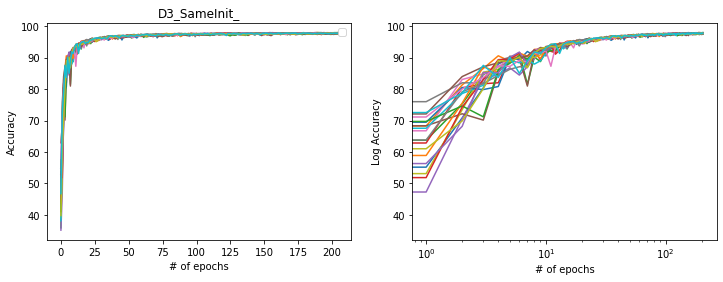

In [1230]:
DFL_accuracy_history = np.load(namebase+'Accuracy.npy', allow_pickle=True)
# DFL_accuracy_history = [d if type(d)==float else sum(d)/len(d) for d in DFL_accuracy_history]
plot_accuracy_history(DFL_accuracy_history, 
#                       log=True, 
                      legend=[],#None, 
                      show_max_only=False, 
#                       accuracy_thresholds=[95,98,98.5,99,99.5], 
                      accuracy_thresholds=[[20,40,50,70],
                                           [80,85,90,93],
                                           [95,96,97,97.5],
                                           [98,98.5,99,99.5]], 
#                       old_compatible=True, 
#                       use_avg=True
#                       use_avg=False
                      title=sgd_type+'_'+postfix
                     )
print(DFL_accuracy_history[-1])

In [1288]:
comm_cost_hist = np.load(namebase+'comm_costs_history.npy', allow_pickle=True)
# comm_cost_hist.shape (K, num_epochs)
print("Total communication cost: ", np.sum(comm_cost_hist)*10/np.prod(comm_cost_hist.shape), "M floats per client per epoch")

sample_count_hist = np.load(namebase+'sample_count_history.npy', allow_pickle=True)
sample_count_hist = np.cumsum(sample_count_hist, axis=1)

print("Average number of samples per epoch per client: ", np.sum(sample_count_hist[:,-1])/np.prod(sample_count_hist.shape))
print(sample_count_hist.shape, np.sum(sample_count_hist[:,-1]))

Total communication cost:  442.96043793949093 M floats per client per epoch
Average number of samples per epoch per client:  256.0
(20, 200) 1024000.0


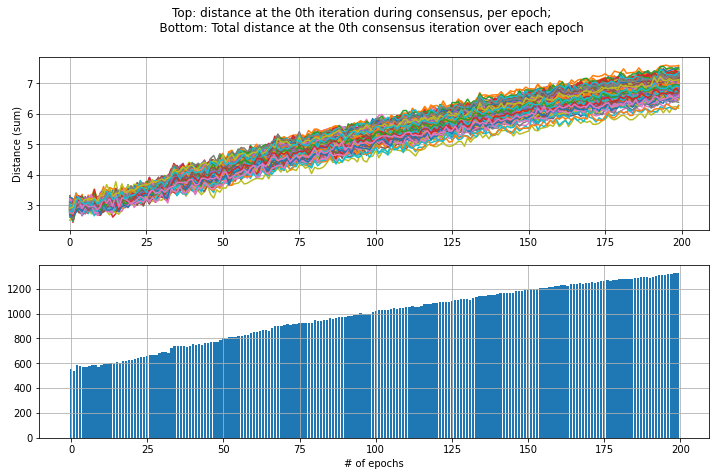

In [1285]:
dists = np.load(namebase+'dists_history.npy')
plot_dist_per_ep(dists[:,:,:,:], uselog=False, avg_iter_ind=0)

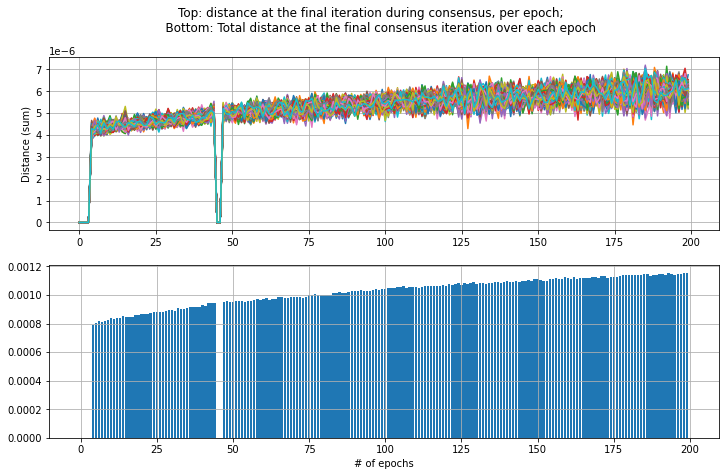

In [1289]:
dists = np.load(namebase+'dists_history.npy')
plot_dist_per_ep(dists, uselog=False, avg_iter_ind=-1)

In [1050]:
segdists = np.load('npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_tryMNIST_no_CRS_record_layer0_EE1_cuSW_B1_-k_4_-Adj_SW_-S_-K_20_-SM_cu_-EE_1_-PSS_0.5_segment_dists.npy')

In [1187]:
segdists.shape

(0,)

In [1201]:
dists.shape

(20, 20, 2, 200)

In [1183]:
dists[0,1,0,60]

12.561962723731995

You can also see the distance trend for one segment/model layer, by carefully transposing the way the distance matrix so that the plotting method interprets it as you wish.

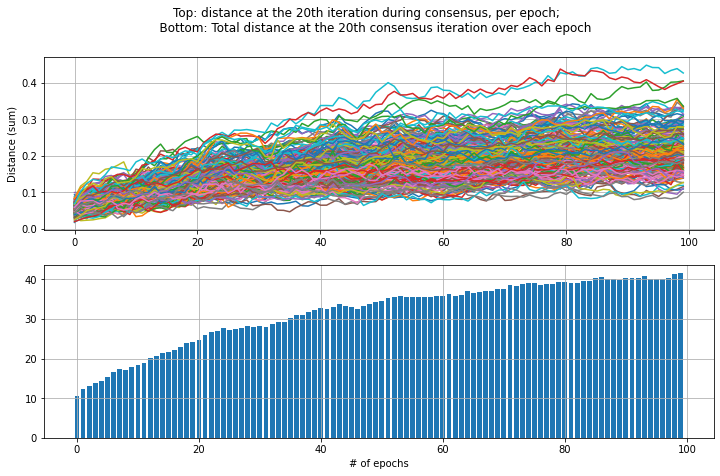

In [1157]:
# Clientwise distance history for one segment
plot_dist_per_ep(segdists[:,:,:,:,15].transpose((3,2,1,0)), uselog=False, avg_iter_ind=20)

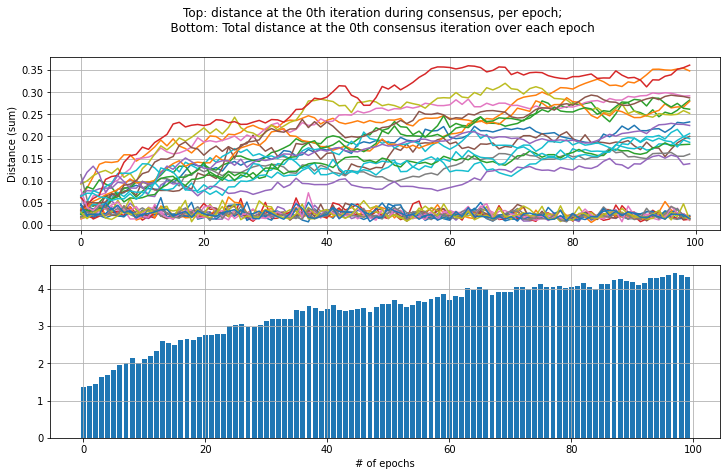

In [1165]:
# Segment distances history for one pair of client
plot_dist_per_ep(np.expand_dims(segdists[:,:,0,1,:].transpose((2,1,0)),0), uselog=False, avg_iter_ind=0)

Text(0.5, 1.0, 'Distance heat map at the -1-th consensus\n iteration of the -11-th epoch')

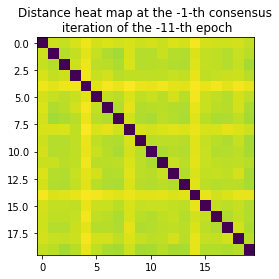

In [503]:
iterind = -1
epochind = -11
plt.imshow(dists[:,:,iterind,epochind])
plt.title("Distance heat map at the {}-th consensus\n iteration of the {}-th epoch".format(iterind,epochind))

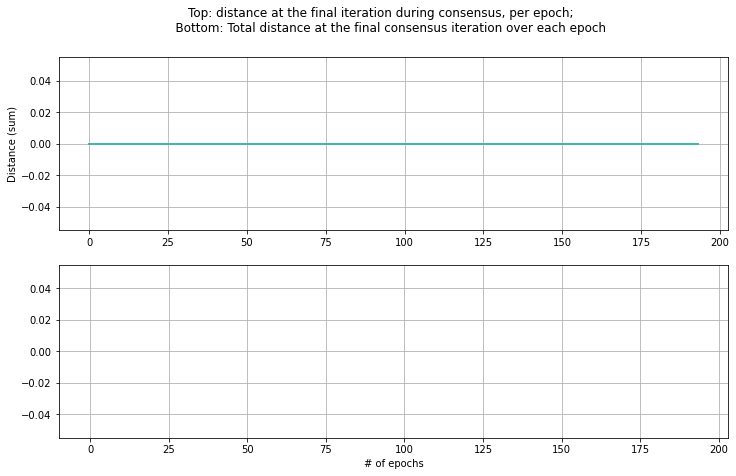

In [1217]:
plot_dist_per_ep(dists[:,:,:,np.sum(dists[:,:,-1,:],axis=(0,1))<=0.01], uselog=False, avg_iter_ind=-1)

## Step 1: Alternatively, you could plot out the results from several different files, as long as you make sure they're all available. The cells below plot out all runs that share the same name (except for one parameter's value).

Accuracy threshold values and corresponding indices: 
[list([20, 40, 50, 70, 80, 85]) list([90, 93, 95, 96, 97])
 list([97.5, 98, 98.5, 99, 99.5])]
[array([1, 1, 2, 3, 4, 5]), array([ 6, 10, 17, 25, 47]), array([81, -1, -1, -1, -1])]
[array([1, 1, 2, 3, 4, 4]), array([ 6,  8, 14, 21, 41]), array([ 56, 108,  -1,  -1,  -1])]
[array([1, 1, 1, 2, 3, 4]), array([ 5,  7, 11, 16, 25]), array([ 36,  58, 143,  -1,  -1])]
[array([1, 1, 1, 2, 3, 4]), array([ 5,  7, 10, 15, 24]), array([ 32,  52, 114,  -1,  -1])]
[array([1, 1, 1, 2, 3, 3]), array([ 5,  6, 10, 14, 23]), array([31, 43, 91, -1, -1])]
Max index and accuracy at there:
[180 201 197 196 202]
[97.8835 98.2225 98.6005 98.672  98.93  ]
Accuracy threshold values and corresponding indices: 
[list([20, 40, 50, 70, 80, 85]) list([90, 93, 95, 96, 97])
 list([97.5, 98, 98.5, 99, 99.5])]
[array([1, 1, 1, 2, 3, 4]), array([ 5,  8, 14, 20, 36]), array([ 57, 148,  -1,  -1,  -1])]
[array([1, 1, 1, 2, 3, 4]), array([ 5,  8, 12, 18, 33]), array([46, 78,

'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_srn_FirstTest_MNIST_cuCRS_B1_-k_4_-Adj_AK_-S_-K_20_-SM_cu_-SRN_-CRS_-PSS_0.25'

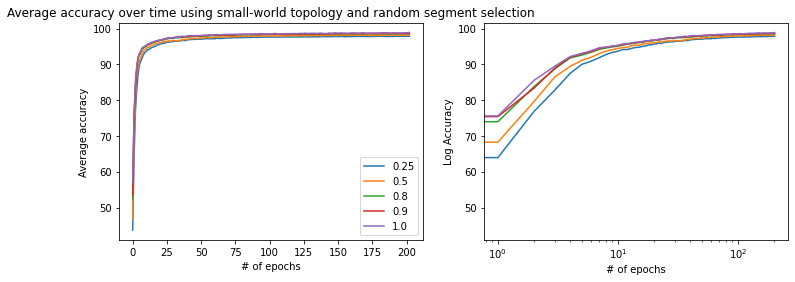

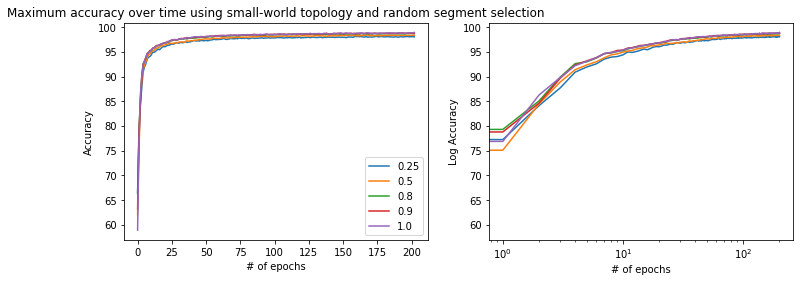

In [1263]:
namebase='npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_c_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_c_-PSS_{1}'.format(
200, 0.1, 'SW')
# nameopt1 = [0.1,0.25,0.5,0.8,1.0]
nameopt1 = [0.25,0.5,0.8,0.9,1.0]
histnames = [
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_c_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_c_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cAK_B1_-k_4_-Adj_AK_-nr_{0}_-S_-K_20_-SM_c_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cURS_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_c_-URS_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cEE1_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_c_-EE_1_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cu{2}_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_cu_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cu{2}_EE1_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_cu_-EE_1_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cu{2}_URS_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_cu_-URS_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cu{2}_B1_-k_4_-Adj_{2}_-nr_{0}_-S_-K_20_-SM_cu_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_segdist_l{2}_B1_-k_4_-Adj_{2}_-S_-K_20_-SM_l_-PSS_{1}'.format(
#     'npy_datas/CIFAR_DFL_reduceComASameInit_dataset_Channel_Undirected_postFix_{2}k4_A_-k_4_-Adj_{2}_-nr_50_-S_-K_20_-EE_1_-SM_cu_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_dataset_tryMNIST_cuAK_B1_-k_4_-Adj_AK_-nr_200_-S_-K_20_-SM_cu_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_tryMNIST_no_CRS_record_layer0_cuSW_B1_-k_4_-Adj_SW_-S_-K_20_-SM_cu_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_tryMNIST_has_CRS_record_layer0_cuSW_B1_-k_4_-Adj_SW_-S_-K_20_-SM_cu_-CRS_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_tryMNIST_has_CRS_record_layer0_EE05_cSW_B1_-k_4_-Adj_SW_-S_-K_20_-SM_c_-EE_0.5_-CRS_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_tryMNIST_has_CRS_record_layer0_cSW_B1_-k_4_-Adj_SW_-S_-K_20_-SM_c_-CRS_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_tryMNIST_no_CRS_record_layer0_EE01_cSW_B1_-k_4_-Adj_SW_-S_-K_20_-SM_c_-EE_0.1_-PSS_{1}'.format(
#     'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_srn_FirstTest_MNIST_cCRS_B1_-k_4_-Adj_AK_-S_-K_20_-SM_c_-SRN_-CRS_-PSS_{1}'.format(
    'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_srn_FirstTest_MNIST_cuCRS_B1_-k_4_-Adj_AK_-S_-K_20_-SM_cu_-SRN_-CRS_-PSS_{1}'.format(
    200, nm, 'SW') for nm in nameopt1
]
legend = nameopt1
titles = [prefix+
          " accuracy over time using small-world topology and random segment selection" for prefix in [
              "Average","Maximum" ]]
old_compatible=False

plot_avg_accuracy_histories(histnames, 
                            legend=nameopt1, 
                            show_max_only=False, use_avg=True, 
                            accuracy_thresholds=[[20,40,50,70,80,85],
                                                 [90,93,95,96,97],
                                                 [97.5,98,98.5,99,99.5]], 
                            old_compatible=old_compatible, 
                            title=titles[0])

plot_avg_accuracy_histories(histnames, 
                            legend=nameopt1, 
                            show_max_only=True, use_avg=False, 
                            accuracy_thresholds=[[20,40,50,70,80,85],
                                                 [90,93,95,96,97],
                                                 [97.5,98,98.5,99,99.5]], 
                            old_compatible=old_compatible, 
                            title=titles[1])
histnames[0]

In [1223]:
segdists = np.load('npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_tryMNIST_no_CRS_record_layer0_EE05_cSW_B1_-k_4_-Adj_SW_-S_-K_20_-SM_c_-EE_0.5_-PSS_0.8_segment_dists.npy')
# Clientwise distance history for one segment
plot_dist_per_ep(segdists[:,:,:,:,15].transpose((3,2,1,0)), uselog=False, avg_iter_ind=20)

FileNotFoundError: [Errno 2] No such file or directory: 'npy_datas/MNIST_DFL_reduceComB1SameInit_postCRS_dataset_srn_FirstTest_MNIST_cu_B1_-k_4_-Adj_AK_-S_-K_20_-SM_cu_-SRN_-PSS_0.25_segment_dists.npy'

In [1200]:
segdists.shape

(0,)

### Code junkyard for experimenting with different plotting methods

In [280]:
def count_occurrences(preds, K=10):
    # Argument: a single list with classifications 0-9
    count_list = [0]*K
    for p in preds:
        count_list[int(p)] += 1
    percentage_list = [c*100.0 / len(preds) for c in count_list]
    return percentage_list

def print_pred_result(preds):
    # Argument: preds is the default thing generated by the script.
    K = len(preds)
    std = count_occurrences(preds[0][1], K)
    answs = [count_occurrences(p[0]) for p in preds]
    return std, answs

In [307]:
rightafter = '_test_preds_rightafter.npy'
pred_1 = (np.load(namebase[:-7]+rightafter))
len(pred_1), len(pred_1[0]), len(pred_1[0][0])
# pred_1: Contains one list for each client
# pred_1[0]: Contains one list for answer and one list for prediction
# pred_1[0][0/1]: Predictions/correct answers for each test sample
right_answers, K_preds = print_pred_result(pred_1)
print("Right answer: \n", right_answers, "\nIndividual answers: \n", np.array(K_preds))

Right answer: 
 [8.5, 12.6, 11.6, 10.7, 11.0, 8.7, 8.7, 9.9, 8.9, 9.4] 
Individual answers: 
 [[ 8.7 12.7 11.5 10.5 11.   9.   8.5 10.1  8.7  9.3]
 [ 9.  10.9 10.5 10.  10.8  9.6  9.1 10.5 10.1  9.5]
 [10.1 10.9  9.3 10.9 10.  10.3  9.1 10.   9.6  9.8]
 [10.2 10.9 10.8  9.2  9.9  8.8 10.4 10.3  9.8  9.7]
 [ 9.2 12.2 11.   9.1  8.1  8.5  8.4 10.2 10.3 13. ]
 [10.8 11.5  9.5  9.5  9.8  9.1 10.   9.7  9.9 10.2]
 [10.2 10.9 10.5 10.8 10.1  8.6  9.4 10.4  9.5  9.6]
 [10.1 11.  10.5 10.1  8.7  9.  10.  10.1 10.6  9.9]
 [10.5 11.1  9.9 10.5 10.1  8.4 10.  10.   9.3 10.2]
 [10.2 11.9 10.  10.2  9.2  8.4 10.4 11.6  9.3  8.8]]


In [308]:
testfinal = '_test_preds_final.npy'
pred_2 = (np.load(namebase[:-7]+testfinal))
right_answers, K_preds = print_pred_result(pred_2)
print("Right answer: \n", right_answers, "\nIndividual answers: \n", np.array(K_preds))

Right answer: 
 [8.5, 12.6, 11.6, 10.7, 11.0, 8.7, 8.7, 9.9, 8.9, 9.4] 
Individual answers: 
 [[ 8.7 12.8 11.6 10.4 10.8  9.   8.5 10.   8.8  9.4]
 [ 9.2 10.9 10.5 10.  10.7  9.7  9.3 10.3 10.   9.4]
 [10.  10.7  9.6 10.5 10.2 10.7  9.1 10.   9.4  9.8]
 [10.6 10.9 10.7  9.5  9.6  8.8 10.3 10.2  9.8  9.6]
 [ 9.2 12.2 11.2  9.   7.9  8.7  8.2 10.3 10.4 12.9]
 [10.8 11.4  9.4  9.7  9.8  9.  10.1  9.7  9.8 10.3]
 [10.3 11.  10.5 10.9 10.1  8.8  9.4 10.4  9.3  9.3]
 [10.3 10.8 10.6 10.   8.7  9.  10.  10.1 10.5 10. ]
 [10.5 11.1  9.9 10.5 10.   8.4 10.  10.   9.3 10.3]
 [10.4 11.9  9.8 10.3  9.2  8.4 10.2 11.6  9.5  8.7]]


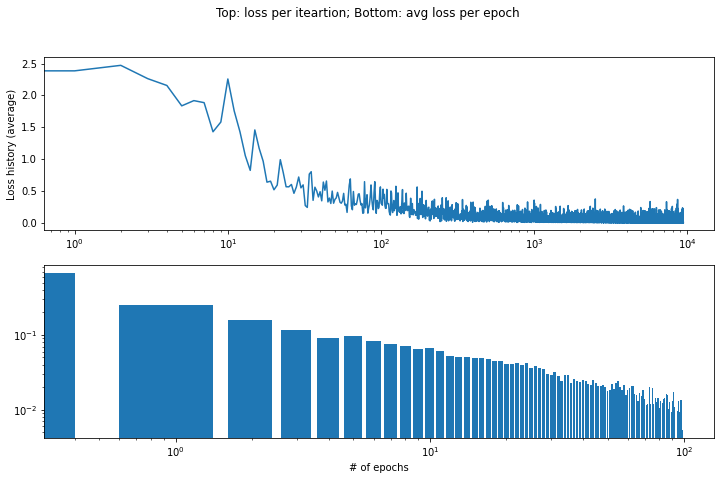

In [140]:
# Plot trainiing loss history of only one client
client_DFL_loss_history = np.load(namebase+'client_1_loss_history.npy')
plot_loss_hist(client_DFL_loss_history)#, uselog=False)

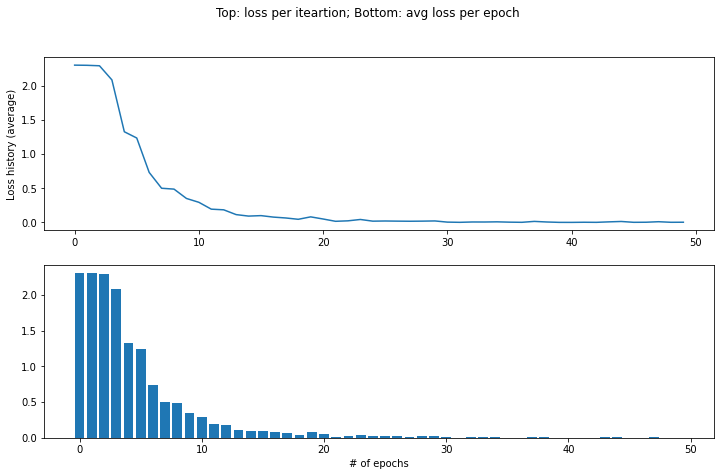

In [54]:
plot_loss_hist([[client_DFL_loss_history[i][0]] for i in range(50)], uselog=False)

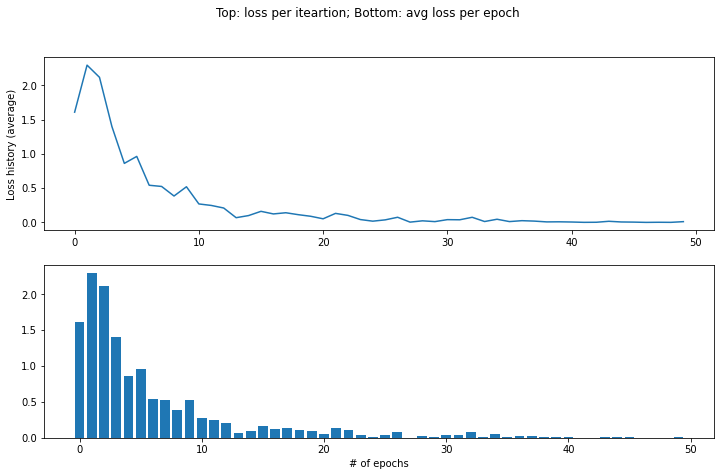

In [56]:
plot_loss_hist([[client_DFL_loss_history[i][-1]] for i in range(len(client_DFL_loss_history))], uselog=False)

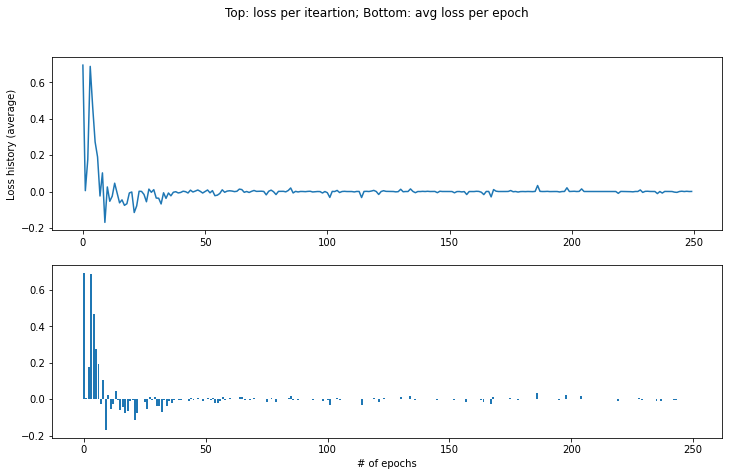

In [57]:
plot_loss_hist([[client_DFL_loss_history[i][0]-client_DFL_loss_history[i][-1]] for i in range(len(client_DFL_loss_history))], uselog=False)

In [369]:
len(client_DFL_loss_history[0])# * len(client_DFL_loss_history)

734

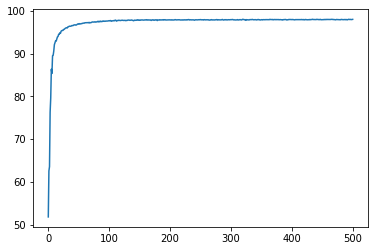

In [525]:
DFL_accuracy_history = np.load(namebase+'Accuracy.npy')
plt.plot(np.arange(len(DFL_accuracy_history)), DFL_accuracy_history)

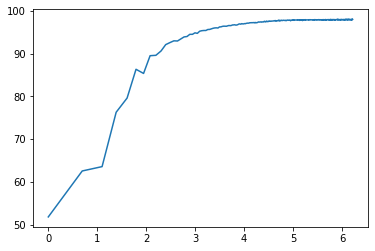

In [526]:
plt.plot(np.log(np.arange(1,len(DFL_accuracy_history)+1)), DFL_accuracy_history)

In [527]:
thres_list = [20,30,40,50,60,  70,80,85,90,  93,95,96,97,  97.5,98,98.5,99,99.5]
find_accuracy_first_thres(DFL_accuracy_history, thres_list)

array([  1,   1,   1,   1,   2,   4,   6,   6,  10,  13,  22,  30,  52,
        82, 287,  -1,  -1,  -1])

In [528]:
Imax = np.argmax(DFL_accuracy_history)
print(Imax, DFL_accuracy_history[Imax])

434 98.06


In [574]:
len(DFL_accuracy_history[0])

30

In [238]:
dists.shape

(10, 10, 2, 250)

In [12]:
dists[:,:,[0,-1],:].shape

(10, 10, 2, 500)

In [307]:
np.argmax(dists[:,:,-1,-1])

228

In [245]:
np.concatenate((dists[:,:,[-1],:], np.zeros((10,10,1,10))),axis=3).shape

(10, 10, 1, 260)

In [243]:
dists[:,:,[-1],:].shape

(10, 10, 1, 250)

In [83]:
dists[:,:,0,1]

array([[0.        , 0.00644467, 0.01948191, 0.00833289, 0.00190375,
        0.00839237, 0.00495976, 0.00668436, 0.00384962, 0.00144954],
       [0.        , 0.        , 0.01438521, 0.00322492, 0.00590674,
        0.00329632, 0.01001929, 0.00157646, 0.0089148 , 0.00651699],
       [0.        , 0.        , 0.        , 0.0125154 , 0.01893962,
        0.01245349, 0.02304947, 0.01417133, 0.0219444 , 0.01954529],
       [0.        , 0.        , 0.        , 0.        , 0.00778406,
        0.00143005, 0.01188774, 0.00299981, 0.01077774, 0.00838902],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00784837, 0.00546791, 0.00613719, 0.0043659 , 0.00197032],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01195554, 0.00307691, 0.01084883, 0.00844239],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01023933, 0.00247911, 0.0048755 ],
       [0.        , 0.        , 0.       

In [257]:
# tmpdists = np.load('ncsns_epsilon_dists_history.npy')
tmpdists = np.load('ncsns_metropolis_dists_history.npy')
# tmpdists = np.load('ncsns_cycle_dists_history.npy')

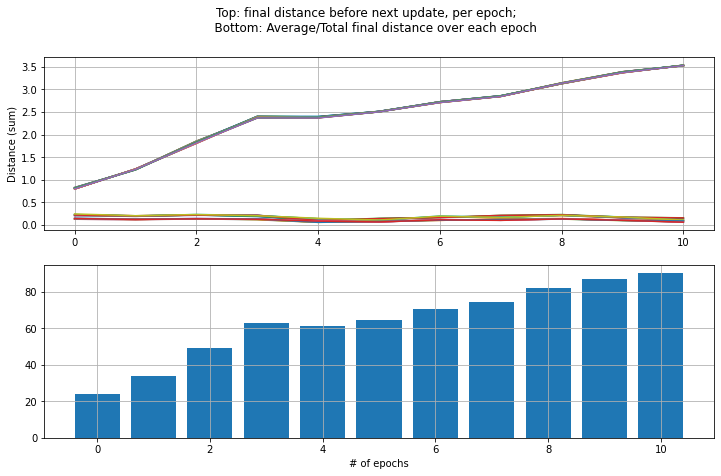

In [259]:
plot_dist_per_ep(tmpdists, uselog=False, avg_iter_ind=9)

In [195]:
tmpdists.shape

(10, 10, 10, 11)

In [230]:
# Experiment with saving
import sys

In [234]:
print(sys.argv)

['/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py', '-f', '/Users/zz/Library/Jupyter/runtime/kernel-1fe8547e-f67b-480f-8154-e01e7d4624de.json']


In [406]:
np.maximum(2, [1,2,3,4,5])

array([2, 2, 3, 4, 5])

In [444]:
sum([3997, 2581, 2549, 10425, 10412, 4434, 8346, 3814, 6791, 6651])

60000

In [445]:
sum([5860, 4491, 4461, 12074, 12061, 6283, 10064, 5683, 8561, 8426])

77964

In [1224]:
np.linspace(0.1,1,10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])